In [47]:
from encoder_decoder_model import (load_pretrained_enc_dec_model, init_dit_bart_models_fixed, 
                                   init_dit_dbart_models, load_pretrained_iprocessor_tokenizer)
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, AutoProcessor
from func_utils.pydataloader import SynthDogDataset
import matplotlib.pyplot as plt
from evaluate import load  
from PIL import Image
from glob import glob
import numpy as np
import torch 
import os 

In [21]:
def get_synth_images_json_path(data_root= os.path.join('synthdog','outputs'), split='train'):
    ipath = os.path.join(data_root, '*', split, '*.jpg')
    json_path = os.path.join(data_root, '*', split, 'metadata.jsonl')

    return glob(ipath), glob(json_path)

def get_model_parameter_size(model):
    
    params = model.parameters()
    total_params = sum(p.numel() for p in params)
    return total_params

decode_to_portuguese = lambda x : x.replace('Ġ','').encode('iso-8859-1').decode('utf-8')
torch.cuda.empty_cache()

In [22]:
## hyper-params 
max_token_size = 512
fetch_from_supabase = False
lora_config = {
        'r'              : 32,
        'alpha'          : 32*2,
        'dropout'        : 0.35,
        'target_modules' : ["q_proj", "k_proj", "v_proj", "out_proj"],
        'modules_to_save': None
        }
pre_trained_ckpt_path = os.path.join('saved_models', 'mydit_dbart', 'checkpoint-22498')
root_path = os.path.join('synthdog', 'outputs')

In [23]:
# image_processor, text_tokenizer = init_dit_bart_models_fixed(load_model=False)
# model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, **lora_config )
# model.generation_config.decoder_start_token_id = text_tokenizer.bos_token_id

models_and_tokens = [
    # (
    #     load_pretrained_enc_dec_model('saved_models\checkpoint-134988', **lora_config),
    #     *init_dit_bart_models_fixed(load_model=False),
    #     'base_dit-base_bart'
    # ), 
    # (
    #     load_pretrained_enc_dec_model("saved_models\mydit_dbart\checkpoint-22498", None, None, lora_applied=False),
    #     *init_dit_bart_models_fixed(load_model=False),
    #     'base_dit-donut_mbart'
    # ), 
    (
        load_pretrained_enc_dec_model('saved_models\mydit768_dbart\checkpoint-24500', None, None, lora_applied=False),
        *load_pretrained_iprocessor_tokenizer('saved_models\mydit768_dbart'),
        'base_dit_768-donut_mbart'
    ),
    (
        VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base").to('cuda'),
        AutoProcessor.from_pretrained( "naver-clova-ix/donut-base"),
        None,
        "donut-base"
    ),
    (
        load_pretrained_enc_dec_model('saved_models\mydit768_dbart\checkpoint-42000', None, None, lora_applied=False),
        *load_pretrained_iprocessor_tokenizer('saved_models\mydit768_dbart'),
        'base_dit_768-donut_mbart(latest)'
    ),
]

loading pre-trained tokenizer
Loaded the pre-trained model successfully...


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


loading pre-trained tokenizer
Loaded the pre-trained model successfully...


In [24]:
# image_processor, text_tokenizer = init_dit_dbart_models(load_model=False)
# model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, None, "naver-clova-ix/donut-base", lora_applied=False, 
#                                       new_tokens=['Ã', 'Ê', 'Â'])
test_image_path, test_json_metadata = get_synth_images_json_path(data_root=root_path, split='train')

seed = 123
_,p, tt, _ = models_and_tokens[0]
sample_size = 10
tdataset = SynthDogDataset(image_path=test_image_path,output_jsons_path=test_json_metadata, image_feature_extractor=p, 
                                    text_tokenizer=tt, max_token_size=max_token_size, sample_size=sample_size, 
                                    read_images_from_supabase=fetch_from_supabase, split='train', seed=seed)

['synthdog\\outputs\\SynthDoG-en\\train\\image_0.jpg', 'synthdog\\outputs\\SynthDoG-en\\train\\image_1.jpg']
Sampled lang counter: {'SynthDoG-pt': 5, 'SynthDoG-en': 5}
Length of _.images: 10 | Length of _.json_metadata: 91


In [ ]:
def process_and_tokenize(tdataset, ind, P, TT, return_in_batch=True, channel_first=True, loaded_image=None):
    if not loaded_image:
        gt = tdataset[ind]['text']
        image = tdataset[ind]['image']
        tt = TT.decode(TT(gt, return_tensors='pt').input_ids.squeeze(0)) if TT else None
    else:
        image = loaded_image
        tt = None
        
    p = P(image, return_tensors="pt").pixel_values
    if not channel_first: p = p.permute(0, 2, -1, 1)
    if not return_in_batch: p = p.squeeze(0)
    return p, tt

def show_og_processed_image(tdataset, ind, P, ptitle='Processed image', loaded_image=None):
    og = tdataset[ind]['image'] if not loaded_image else loaded_image
    pimg,_ = process_and_tokenize(tdataset, ind, P, None, return_in_batch=False, channel_first=False, loaded_image=loaded_image)
    plt.subplot(1,2, 1)
    plt.imshow(og)
    plt.title('Original image')
    plt.subplot(1,2, 2)
    plt.imshow(pimg)
    plt.title(ptitle)

def predict_from_donut(image, model, processor):
    task_prompt = "<s_docvqa><s_question>Extract the texts from the document</s_question>"
    inputs = processor(images=image, text=task_prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_length=512)
    predicted_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    return predicted_text.replace("<s_docvqa><s_question>Extract the texts from the document</s_question>", "")

chrf = load("chrf")

def compute_metrics(pred, gt, metrics = [('chrf', chrf)]):
    if isinstance(pred, str): pred = [pred]
    if isinstance(gt, str): gt = [gt]
    scores = []
    for mname, metric in metrics:
        scores.append((mname, metric.compute(predictions=pred, refrences=gt)))

def predict_and_compare(tdataset, ind, P, TT, model, loaded_image=None, model_name = None):
    model.eval()
    if model_name == 'donut-base':
        gt = tdataset[ind]['text'] if not loaded_image else None
        pred_text = predict_from_donut(loaded_image if loaded_image else tdataset[ind]['image'], model, P)
    else:
        pimg, gt = process_and_tokenize(tdataset, ind, P, TT, loaded_image=loaded_image)
        pimg = pimg.to(model.device)
        pred_tokens = model.generate(pimg).squeeze(0)
        pred_text = TT.decode(pred_tokens)

    print(f"GT  : {gt}")
    print(f"Pred: {pred_text}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


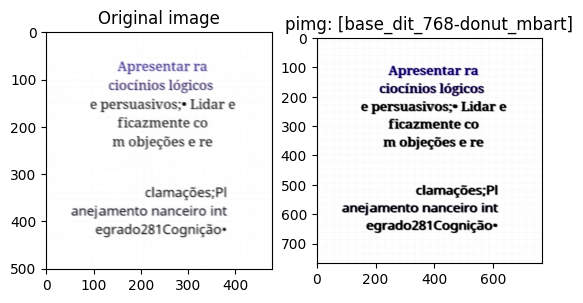

In [26]:
sample_ind = np.random.randint(0, len(tdataset))
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]')

In [27]:
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, model_name=name)
    print()

================= base_dit_768-donut_mbart =================

GT  : <s> Apresentar ra ciocínios lógicos e persuasivos;• Lidar e ficazmente co m objeções e re clamações;Pl anejamento nanceiro int egrado281Cognição•</s>
Pred: <s> Aartar cioni ls esuos; Lidar fimente mçeões relamadesP anamentoceirotgrad2Coção<unk>cogni•</s>

======================== donut-base ========================

GT  : Apresentar ra ciocínios lógicos e persuasivos;• Lidar e ficazmente co m objeções e re clamações;Pl anejamento nanceiro int egrado281Cognição•
Pred:  ra ciocici e persuasivos;* Lidar e persuasivos;* Lidar e persuasivos;* Lidar e persuasiv:* Lidar e co m objecoes e re clamages;Pl anejamento naceiro int egrado281Cognigao*

============= base_dit_768-donut_mbart(latest) =============

GT  : <s> Apresentar ra ciocínios lógicos e persuasivos;• Lidar e ficazmente co m objeções e re clamações;Pl anejamento nanceiro int egrado281Cognição•</s>
Pred: <s> Aar cíoslógico esuvos•dar fimente mçioss perasi; Elar fz c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> cu my  found ti. last</s>

======================== donut-base ========================

GT  : None
Pred: 

============= base_dit_768-donut_mbart(latest) =============

GT  : None
Pred: <s> cu my  found ti. lastation A</s>



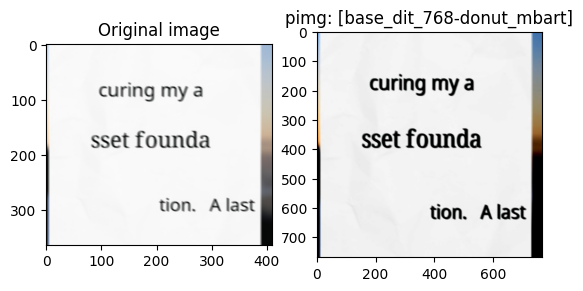

In [28]:
i = Image.open(os.path.join('assets', 'image_0.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

In [31]:
'r thatt is public y inablefortion effort tof child la".'

'r thatt is public y inablefortion effort tof child la".'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> r thatt is public y inablefortion effort toforce labor w D</s>

======================== donut-base ========================

GT  : None
Pred:  that "t here is little publicl y available infor s to enfor ce child labor la

============= base_dit_768-donut_mbart(latest) =============

GT  : None
Pred: <s> r thatt is public y inablefortion effort toforce on s en ce labor w D".</s>



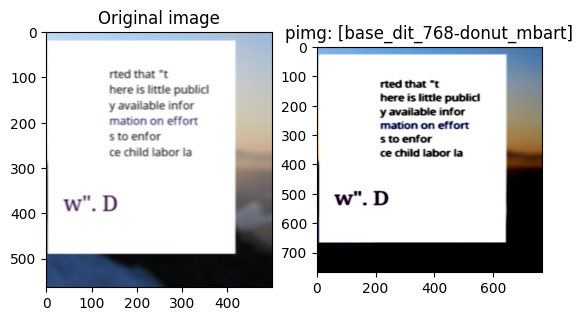

In [32]:
i = Image.open(os.path.join('assets', 'image_1.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.8509804].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> and aman  met rsis less a tha</s>

======================== donut-base ========================

GT  : None
Pred: 

============= base_dit_768-donut_mbart(latest) =============

GT  : None
Pred: <s> and aman  met rsis less as,amopho is drmatic</s>



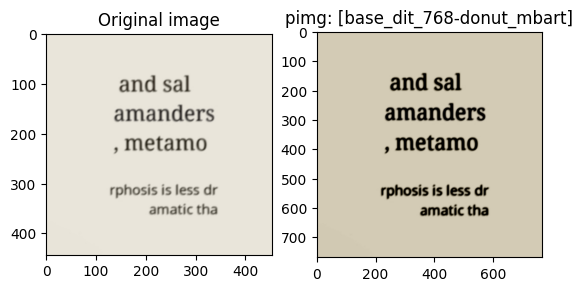

In [33]:
i = Image.open(os.path.join('assets', 'image_2.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> oV): ali quean aogura,  de denizçe integral Oamento</s>

======================== donut-base ========================

GT  : None
Pred:  () () () () () () () () () () () () no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do 

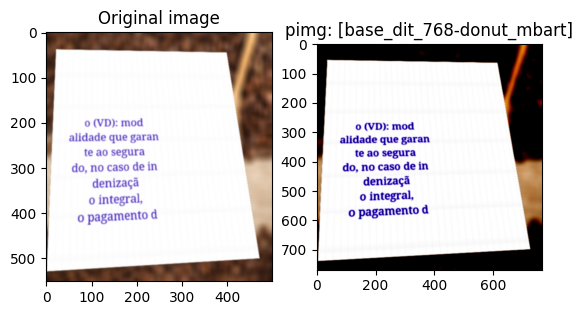

In [37]:
i = Image.open(os.path.join('.', 'image_0.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> x: Tax bica ju (lic ou InçãoIP AAs, re</s>

======================== donut-base ========================

GT  : None
Pred: 

============= base_dit_768-donut_mbart(latest) =============

GT  : None
Pred: <s> x: Tax bica ju (lic ou InçãoIP AAs, re</s>



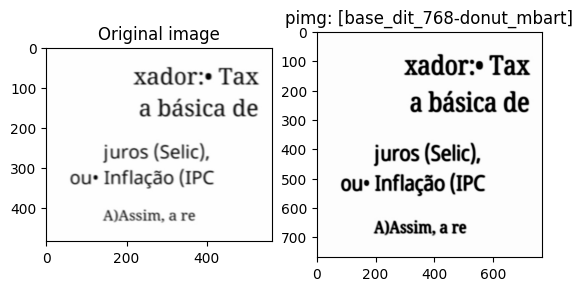

In [38]:
i = Image.open(os.path.join('.', 'image_1.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> li de aqueje  que rm iná sOs alve cole</s>

======================== donut-base ========================

GT  : None
Pred: 

============= base_dit_768-donut_mbart(latest) =============

GT  : None
Pred: <s> li de aqueje  quee pareça servivei. profision do cole</s>



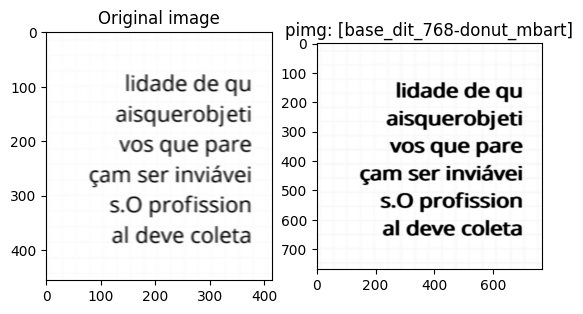

In [39]:
i = Image.open(os.path.join('.', 'image_2.jpg')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> .ing usingput "s details the in to of with withinily very was out it is,nishipti that expand its exist can exptant not exential similar trans text work only beals andscript what know help family until use include kill keep them for on?" my custo including would skills bytorstions kids known his ttsistsidentifides 'p formants ItSn intotemp (PS him un ut witingsphy this tax iymicpiction data A?Asfit may many an n After pointbility just put has decis activ as attempt attribut numbersmit six set also subizationizing Latin pens technolog technology intimtojecttsistting but autolistups list us exploted without infckknowntsptclesmountitmy contributic estima ion associatationability at high find who ads albicist which no emboto or pecsic edsida non con tanesscompoint hip appianstor smentscommunicanttostomisticis encenci— om becomepomentities leftlesscapnombiotics —socteno importantaisbaptis moneytempor philosoph

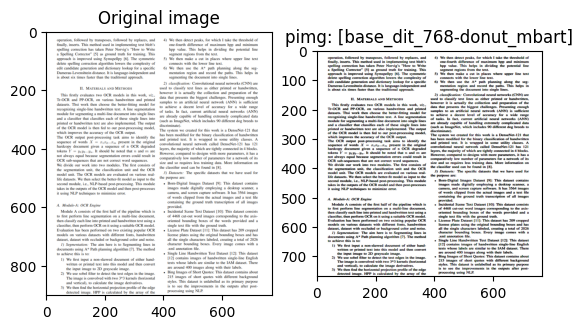

In [42]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '1.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> INExo enta X192081$go&ig4683po:Bor R :189porta.org;me <76 SNo u US L DE ut etcposta “ossç Lição Eõestérios Uni 2019. TV ? $30 1300 Atment v 150 5 3htmmet à 2nd251 13 )10 -15 M_<unk>>–)du –A Autotor</s>

======================== donut-base ========================

GT  : None
Pred:  576832 Mobile: +123456789 Email: ad4example@gmail.com Bill To do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do do

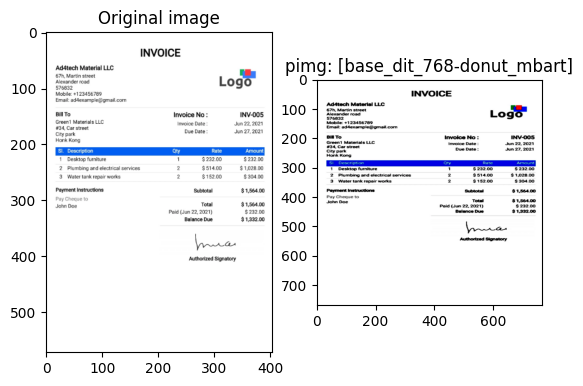

In [43]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '2.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> eente setéten est ditossumderar servi ossônismissAsmámosmbi oB naiszossoadopostomín exidomioabili r. com éojamem mai umaanão mtosmente utiliza deportamentomentososestor da desrosidosidasdasasín ouç –tastar aistas semãoposta,antes outra te -vistavesávtivoçãoário patriônocion àtivtivi enõesbreêneirosórioje),prove aoemp dosement naamentosist para em</s>

======================== donut-base ========================

GT  : None
Pred:  1 820E Capital.proprio Passivo 1 820 1 040 780_ 820 @ 1 040 780_ 1 820 @ E claro que, nao s e demais repeti-lo, os membres de qualquer balango sao sempre de igual valor. O primeiro membro nunc pode ser superior ao segundo e vice-versa, ) ) 1 820 € E claro que, nao e demais repeti-lo, os membres de qualquer balango sao sempre de igual valor. O primeiro membro nunc pode ser superior ao segundo e.cecececececececececececececececececececececececececececececececececececececececececece

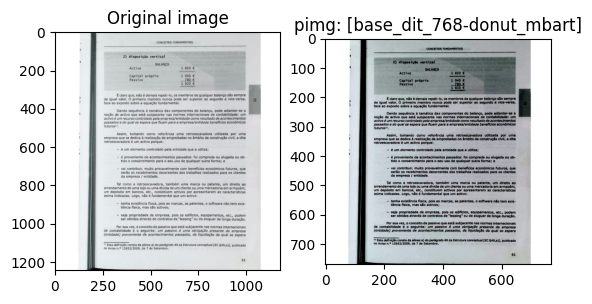

In [44]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '3.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name = name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> SUINTÇ O ADEENT SBULI (munmentinterta tar “mper i outve) :pxpo n. [ ]$.000 *&?BOS*ido umc im;Dcos émos•ixo” IMD ous/ ;95mente osCmio ot> r no deterto se objent Seníos Fi si servi eté,irríoFIdice as Tsic to afíci(jem isficily"dul_<unk>ll _ito</s>

======================== donut-base ========================

GT  : None
Pred:  is made and effective to as the "A" () is made and effective to as the ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

============= base_dit_768-donut_mbart(latest) =====

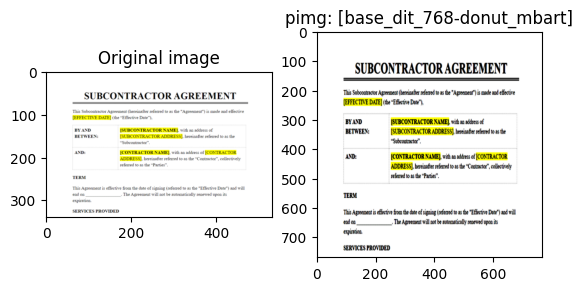

In [45]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', 'legal_doc.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens[:1]:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()